In [1]:
from zipfile import ZipFile
zf = ZipFile('D:\Assignment 6\hvc_data.zip', 'r')
zf.extractall('D:\Assignment 6\\')
zf.close()




# !unzip -q "D:\Assignment 6\hvc_data.zip"
# # look for `hvc_annotations.csv` file and `resized` dir
# %ls 

In [2]:
#%tensorflow_version 1.x

BATCH_SIZE = 512 #@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE = 0.01 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS = 10 #@param {type:"integer"}

In [3]:

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

# from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


from keras.applications import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
import keras
import numpy as np

Using TensorFlow backend.


In [4]:
# load annotations
df = pd.read_csv("D:\Assignment 6\hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [5]:
df['image_path']='D://Assignment 6//'+ df['image_path']

In [6]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,D://Assignment 6//resized/1.jpg,D://Assignment 6//resized/2.jpg,D://Assignment 6//resized/3.jpg,D://Assignment 6//resized/4.jpg,D://Assignment 6//resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [7]:


def parseDF(one_hot_df):
    
    # Label columns per attribute
    _gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
    _imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
    _age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
    _weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
    _carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
    _footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
    _emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
    _bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]



    images = np.stack([cv2.imread(item["image_path"]) for _, item in one_hot_df.iterrows()])
    X_train=images
    

    target={
        
                "gender_output": one_hot_df[_gender_cols_].values,
                "image_quality_output": one_hot_df[_imagequality_cols_].values,
                "age_output": one_hot_df[_age_cols_].values,
                "weight_output": one_hot_df[_weight_cols_].values,
                "bag_output": one_hot_df[_carryingbag_cols_].values,
                "pose_output": one_hot_df[_bodypose_cols_].values,
                "footwear_output": one_hot_df[_footwear_cols_].values,
                "emotion_output": one_hot_df[_emotion_cols_].values
                    }


    Y_train=target
    
    return X_train,Y_train 

In [8]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15)
train_df.shape, val_df.shape
X_train,y_train=parseDF(train_df)

X_test,y_test=parseDF(val_df)


In [9]:
y_train['gender_output']


array([[0, 1],
       [1, 0],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [0, 1]], dtype=uint8)

In [10]:
import matplotlib.pyplot as plt
plt.imshow(X_train[11111])
plt.show()

<Figure size 640x480 with 1 Axes>

In [11]:
y_train

{'gender_output': array([[0, 1],
        [1, 0],
        [0, 1],
        ...,
        [1, 0],
        [1, 0],
        [0, 1]], dtype=uint8), 'image_quality_output': array([[1, 0, 0],
        [0, 0, 1],
        [1, 0, 0],
        ...,
        [0, 0, 1],
        [1, 0, 0],
        [1, 0, 0]], dtype=uint8), 'age_output': array([[0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
        ...,
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0]], dtype=uint8), 'weight_output': array([[1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        ...,
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 1, 0]], dtype=uint8), 'bag_output': array([[1, 0, 0],
        [1, 0, 0],
        [0, 0, 1],
        ...,
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]], dtype=uint8), 'pose_output': array([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        ...,
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], dtype=uint8), 'footwear_output

In [12]:
height=[]
width=[]
channel=[]

for idx in range(train_df.shape[0]):
    img=cv2.imread(train_df['image_path'].iloc[idx])
    height.append(img.shape[0])
    width.append(img.shape[1])
    channel.append(img.shape[2])
    
print(min(height))
print(min(width))
print(min(channel))


print(max(height))
print(max(width))
print(max(channel))  

224
224
3
224
224
3


In [13]:
import tensorflow as tf
class Conv3BN(tf.keras.Model):
    def call(self, inputs):
        return tf.nn.relu(self.bn(self.drop(self.conv(inputs))))
    
    def __init__(self, c_out):
        super().__init__()
        self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3,padding="SAME",
                                           kernel_initializer=keras.initializers.VarianceScaling(scale=1.0, mode='fan_in', distribution='normal', seed=None),
                                           use_bias=False)
        self.bn = tf.keras.layers.BatchNormalization()
        self.drop = tf.keras.layers.Dropout(0.05)
        self.c_out=c_out
            


In [14]:
import tensorflow as tf
class Conv1BN(tf.keras.Model):
    def call(self, inputs):
        return tf.nn.relu((self.conv(inputs)))
    
    def __init__(self, c_out):
        super().__init__()
        self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=1,padding="SAME",
                                           kernel_initializer=keras.initializers.VarianceScaling(scale=1.0, mode='fan_in', distribution='normal', seed=None),
                                           use_bias=False)  #padding="SAME",
                          
        self.bn = tf.keras.layers.BatchNormalization()
        self.drop = tf.keras.layers.Dropout(0.05)

            


In [15]:
class CNN_blk(tf.keras.Model):
    
    def __init__(self, c_out ,pool,flag=False):
        
        super().__init__()
        self.conv_bn = Conv3BN(c_out)
        self.pool=pool
        self.flag=flag
        
    def call(self, inputs):
        if(self.flag==True):
            h=self.pool(self.conv_bn(inputs))
        else:
            h = self.conv_bn(inputs)
        return h

In [16]:
32/2

16.0

In [31]:

class MLNet(tf.keras.Model):
    
    def __init__(self, c=32, weight=0.125):
        super().__init__()
        
        pool = tf.keras.layers.MaxPooling2D()
        self.init_conv_bn = Conv3BN(c)
        self.init_conv1_bn=Conv1BN(int(c/2))
        self.blk0 = CNN_blk(c,pool,False)
        self.blk1 = CNN_blk(c*2,pool,True)
#         self.blk2 = CNN_blk(c*4, pool,False)
#         self.blk3 = CNN_blk(c*8, pool,True)
#         self.blk4 = Conv1BN(c)
        self.pool = tf.keras.layers.GlobalAveragePooling2D()
        
        self.init_conv2=Conv1BN(int(c/16))
        self.linear = tf.keras.layers.Dense(2,kernel_initializer=keras.initializers.VarianceScaling(scale=1.0, mode='fan_in', distribution='normal', seed=None),use_bias=False)
        self.weight = weight

    def call(self, x, y):
        

#         h= self.init_conv1_bn(self.blk3(self.blk2(self.blk1(self.init_conv_bn(x)))))

        h= self.blk1(self.init_conv_bn(x))
#         h= self.init_conv1_bn(self.blk3(self.blk2(self.blk1(self.blk0(h)))))

#         h= self.init_conv1_bn(self.blk3(self.blk2(self.blk1(self.blk0(h)))))

#         h= self.init_conv1_bn(self.blk3(self.blk2(self.blk1(self.blk0(h)))))

#         h= self.init_conv1_bn(self.blk3(self.blk2(self.blk1(self.blk0(h)))))

        h=self.init_conv2(h)

        h= self.pool(h)


        h = self.linear(h) * self.weight
        

        ce = tf.nn.sigmoid_cross_entropy_with_logits(logits=h, labels=y)

        loss = tf.reduce_sum(ce)

        h=tf.cast(h, tf.int64 )
        y=tf.cast(y, tf.int64 )

        correct = tf.reduce_sum(tf.cast(tf.math.equal(h, y), tf.int64 ))#tf.argmax(h, axis = 1)
        return loss, correct

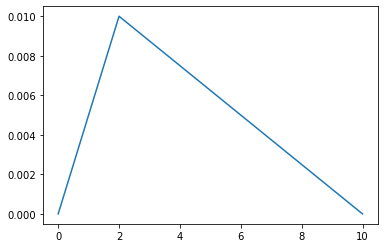

In [32]:
import matplotlib.pyplot as plt
plt.plot([0, (EPOCHS+1)//5, EPOCHS], [0, LEARNING_RATE, 0])

In [33]:

model = MLNet()
len_train=11537
len_test=2036
batches_per_epoch = len_train//BATCH_SIZE + 1

lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS], [0, LEARNING_RATE, 0])[0]
global_step = tf.Variable(1, name="global_step")
lr_func = lambda: lr_schedule(global_step/batches_per_epoch)/BATCH_SIZE
opt = tf.compat.v1.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)
# data_aug = lambda x, y: (tf.image.random_flip_left_right(tf.image.random_crop(x, [32, 32, 3])), y)

In [20]:
train_mean = np.mean(X_train, axis=(0,1,2))
train_std = np.std(X_train, axis=(0,1,2))

normalize = lambda x: ((x - train_mean) / train_std).astype('float32')
X_train = normalize(X_train)
X_test = normalize(X_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


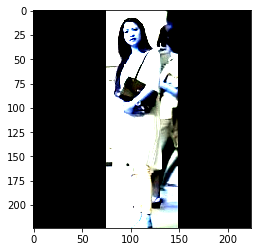

In [21]:
X_train.shape
plt.imshow(X_train[1])

In [22]:
np.save("y_test.npy", y_test)
np.save("y_train.npy", y_train)

In [23]:
from numpy import savez_compressed
savez_compressed('Normalized image data.npz', X_train, X_test)
# savez_compressed('Normalized test data.npz', X_test, y_test)

In [24]:
# load prepared planet dataset
from numpy import load
data = load('Normalized image data.npz', allow_pickle=True)
X_train, X_test = data['arr_0'], data['arr_1']
print('Loaded: ', X_train.shape, X_test.shape)

y_train=np.load('y_train.npy', allow_pickle=True)
y_test=np.load('y_test.npy', allow_pickle=True)

Loaded:  (11537, 224, 224, 3) (2036, 224, 224, 3)


In [25]:
y_train.item().get('gender_output')

array([[0, 1],
       [1, 0],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [0, 1]], dtype=uint8)

In [26]:
label_train=y_train.item().get('gender_output').astype('float32')
label_test=y_test.item().get('gender_output').astype('float32')

# label_train=y_train
# label_test=y_test

In [27]:
test_set_X = tf.data.Dataset.from_tensor_slices(X_test).shuffle(label_test.shape[0]).batch(BATCH_SIZE).prefetch(1) 
test_set_Y =tf.data.Dataset.from_tensor_slices(label_test).shuffle(label_test.shape[0]).batch(BATCH_SIZE).prefetch(1)

In [ ]:
for epoch in range(EPOCHS):
    train_loss = test_loss = train_acc = test_acc = 0.0
    
    data_aug = lambda x: tf.image.random_crop(x, [32, 32, 3])   
    # using tf.data.Dataset.from_tensor_slices() method 
    train_set_X = tf.data.Dataset.from_tensor_slices(X_train).shuffle(len_train).batch(BATCH_SIZE).prefetch(1) 
    train_set_Y =tf.data.Dataset.from_tensor_slices(label_train).shuffle(len_train).batch(BATCH_SIZE).prefetch(1)  
    
#     train_set = tf.data.Dataset.from_tensor_slices((x_train, label_train)).map(data_aug).shuffle(len_train).batch(BATCH_SIZE).prefetch(1)

    tf.keras.backend.set_learning_phase(1)
    for (x, y) in tqdm(zip(train_set_X,train_set_Y)):
        with tf.GradientTape() as tape:
            loss, correct = model(x, y)
        
        var = model.trainable_variables
        grads = tape.gradient(loss, var)
            
        for g, v in zip(grads, var):
            g += v * WEIGHT_DECAY * BATCH_SIZE
        opt.apply_gradients(zip(grads, var), global_step=global_step)

        train_loss += loss.numpy()
        train_acc += correct.numpy()

        tf.keras.backend.set_learning_phase(0)
        for (x, y) in zip(test_set_X,test_set_Y):
            
            loss, correct = model(x, y)
            test_loss += loss.numpy()
            test_acc += correct.numpy()

        print('epoch:', epoch+1, 'lr:', lr_schedule(epoch+1), 'train loss:', train_loss / len_train, 'train acc:', train_acc / len_train, 'val loss:', test_loss / len_test, 'val acc:', test_acc / len_test)


0it [00:00, ?it/s]

In [ ]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [ ]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='D:/model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')